# 15-body Solar System integration

<ul id="top">
    <li><a href="#Loading-packages-and-functions">Loading packages and functions</a></li>
    <li><a href="#Definition-of-the-N-body-problem">Definition of the N-body problem</a></li>
    <li><a href="#Integration">Integration</a></li>
        <ul>
            <li><a href="#Orbits-of-planets-and-asteroids">Orbits of planets and asteroids</a></li>
            <li><a href="#Error-in-Energy">Error in Energy</a></li>
            <li><a href="#Close-encounters-between-asteroids">Close encounters between asteroids</a></li>
        </ul>
        
</ul>

## Loading packages and functions

In [1]:
using LinearAlgebra, Plots


In [2]:
PATH_SRC_SIMD="../../src/simd/"
include(string(PATH_SRC_SIMD,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD   
 

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem


In Nbody.jl below, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODE1!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}


### Initial value problem: 15-body model of the Solar System


- The Sun, all eight planets of the Solar System, Pluto and the five main bodies of the asteroid belt.
- We consider the initial values at Julian day (TDB) 2440400.5 (the 28th of June of 1969), obtained
form the DE430 ephemerides

In [3]:
setprecision(BigFloat, 108);

In [4]:
PATH_ODES="../../ODEProblems/"

include(string(PATH_ODES,"Initial15Body.jl"))
include(string(PATH_ODES,"Nbody.jl"));

In [5]:
fltype=Float64

u0, Gm, bodylist = Initial15Body(fltype)
show(bodylist)

["Sun" "Mercury" "Venus" "EMB" "Mars" "Jupiter" "Saturn" "Uranus" "Neptune" "Pluto" "Ceres" "Pallas" "Vesta" "Iris" "Bamberga"]

In [6]:
t0=fltype(0.)
tF=fltype(-2e4)  
tspan= (t0,tF)
prob = ODEProblem(NbodyODE_fstep!, u0,tspan , Gm);

##### <a href="#top">Back to the top</a>

## Integration

In [7]:
Dtau=fltype(1.8)
alg= IRKNGL_simd(initial_extrapolation=true)
sol=solve(prob, alg, adaptive=true, dt = Dtau)
sol.retcode

ReturnCode.Success = 1

### Orbits of planets and asteroids

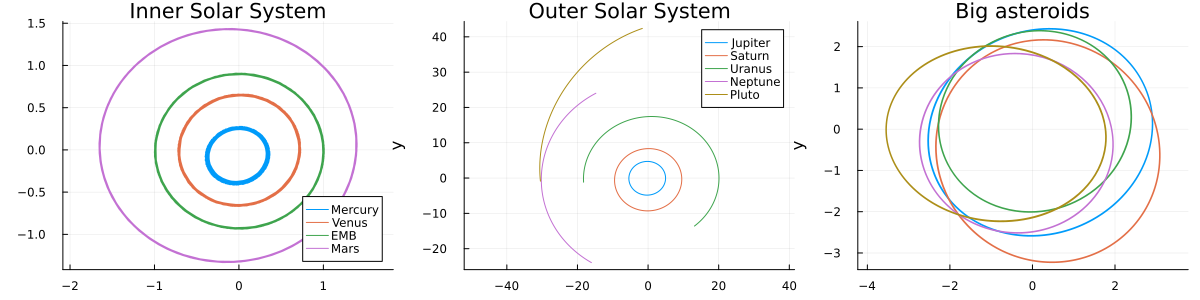

In [8]:
pl1 = plot(title="Inner Solar System", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 2:5
    x  = [u[1,j,1] for u in sol.u]
    y  = [u[2,j,1] for u in sol.u] 
    pl1 = plot!(x,y, label=bodylist[j]) 
end 


pl2 = plot(title="Outer Solar System", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 6:10
    x  = [u[1,j,1] for u in sol.u]
    y  = [u[2,j,1] for u in sol.u] 
    pl2 = plot!(x,y, label=bodylist[j]) 
end 


pl3 = plot(title="Big asteroids", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 11:15
    x  = [u[1,j,1] for u in sol.u]
    y  = [u[2,j,1] for u in sol.u] 
    pl3 = plot!(x,y, 
        label="")
end 


plot(pl1,pl2,pl3, layout=(1,3), size=(1200,300))

In [9]:
savefig("./BodyOrbits.png")

"/home/mikel/Mahaigaina/Work-2023-2024/PIC/PIC-2023-2024/Softwarea/2-IRKGL_SIMD/IRKGL_rebersiblea (nbody)/inplementazioa/Experiments/Examples/BodyOrbits.png"

### Error in Energy

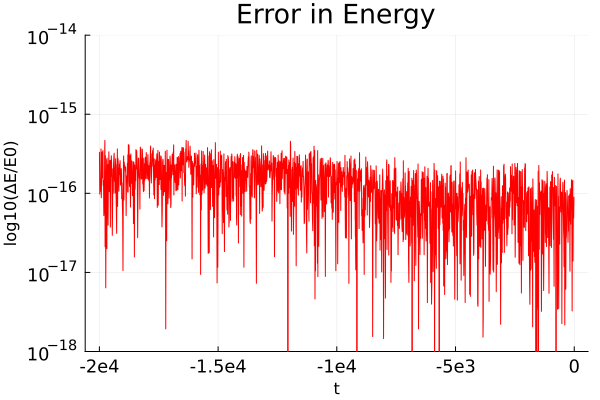

In [10]:
yrange=(1e-18,1e-14)

E0=NbodyEnergy(BigFloat.(u0), BigFloat.(Gm))
ΔE = map(x->NbodyEnergy(BigFloat.(x),BigFloat.(Gm)), sol.u)./E0.-1;


pl1=plot(title="Error in Energy", xlabel="t", ylabel="log10(ΔE/E0)",
        titlefontsize=18,
        xtickfont = font(12),
        ytickfont = font(12),
        xticks=([-2e4,-1.5e4,-1e4,-5e3, 0],["-2e4","-1.5e4","-1e4","-5e3", "0"]),
        yscale=:log10,
        legend=:topright, ylims=yrange)

plot!(pl1,sol.t[2:end-1],abs.(ΔE[2:end-1]), color=:red, label="")

In [11]:
savefig("./EnergyError.png")

"/home/mikel/Mahaigaina/Work-2023-2024/PIC/PIC-2023-2024/Softwarea/2-IRKGL_SIMD/IRKGL_rebersiblea (nbody)/inplementazioa/Experiments/Examples/EnergyError.png"

### Close encounters between asteroids

In [15]:
n=length(sol.t)
dist=Array{Vector{Float64}}(undef,5,5)
for i in 1:5
    for j in 1:5
        dist[i,j]=zeros(n)
    end
end

for i in 1:5
    ix=10+i        # indices for asteroids: 11:15
    A=[u[:,ix,1]  for u in sol.u]
    for j in i+1:5
        jx=10+j   # indices for asteroids: 11:15
        B=[u[:,jx,1]  for u in sol.u]
        dist[i,j]=map(x->norm(x), A-B)
    end
end

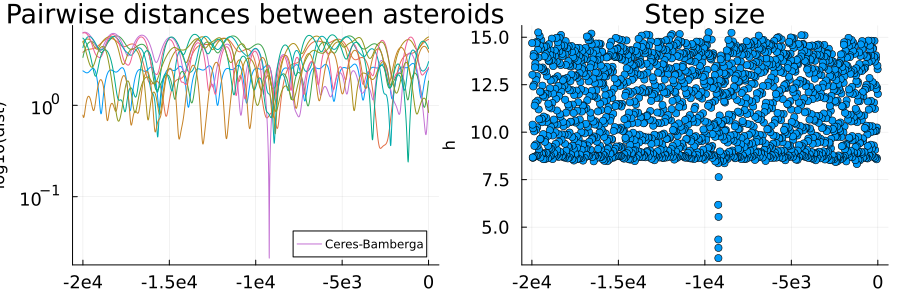

In [16]:
pl1 = plot(title="Pairwise distances between asteroids", 
           titlefontsize=18,
           xtickfont = font(12),
           ytickfont = font(12),
           yscale=:log10,
           legend=:bottomright,
                   xticks=([-2e4,-1.5e4,-1e4,-5e3, 0],["-2e4","-1.5e4","-1e4","-5e3", "0"]),
           xlabel="t", ylabel="log10(dist)")


for i in 1:5
    for j in i+1:5
        if (i==1 && j==5)
             plot!(pl1, sol.t,dist[i,j], label="Ceres-Bamberga")
        else
            plot!(pl1, sol.t,dist[i,j], label="")
        end
    end
end



pl2= scatter(title="Step size",
             titlefontsize=18,
             xtickfont = font(12),
             ytickfont = font(12),
             xticks=([-2e4,-1.5e4,-1e4,-5e3, 0],["-2e4","-1.5e4","-1e4","-5e3", "0"]),
             xlabel="t", ylabel="h",
             label="",
             sol.t[1:end-2],
             abs.(sol.t[2:end-1].-sol.t[1:end-2]))


plot(pl1,pl2, layout=(1,2), size=(900,300))

In [17]:
savefig("./CloseEncounter.png")

"/home/mikel/Mahaigaina/Work-2023-2024/PIC/PIC-2023-2024/Softwarea/2-IRKGL_SIMD/IRKGL_rebersiblea (nbody)/inplementazioa/Experiments/Examples/CloseEncounter.png"